In [1]:
import os
import json
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, AutoModelForCausalLM, pipeline
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
input_text = chunk_data["full_cot"]

In [5]:
import json
import os

# Define the base directory for the problem files
problem_dir = "math-rollouts/deepseek-r1-distill-llama-8b/temperature_0.6_top_p_0.95/correct_base_solution/problem_330"

# The directory containing the solution file
# chunk_dir = "chunk_0"
# The name of the solution file
chunk_filename = "chunks_labeled.json"

# Construct the full path to the solutions.json file
chunk_path = os.path.join(problem_dir, chunk_filename)

try:
    with open(chunk_path, 'r') as f:
        # Load the JSON content from the file
        chunk_data = json.load(f)

    print(f"Content of {chunk_filename}:")
    # Pretty-print the JSON object for better readability
    print(json.dumps(chunk_data, indent=2))

except FileNotFoundError:
    print(f"Error: The file {chunk_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: The file {chunk_path} is not a valid JSON file.")

Content of chunks_labeled.json:
[
  {
    "chunk": "Alright, so I've got this math problem here that I need to solve.",
    "chunk_idx": 0,
    "function_tags": [
      "problem_setup"
    ],
    "depends_on": [],
    "accuracy": 0.21428571428571427,
    "resampling_importance_accuracy": 0.3157142857142857,
    "resampling_importance_kl": 9.539380788051231,
    "counterfactual_importance_accuracy": -0.3871428571428572,
    "counterfactual_importance_kl": 10.809324976891892,
    "forced_importance_accuracy": 0.0,
    "forced_importance_kl": 14.21827053440187,
    "different_trajectories_fraction": 0.8571428571428571,
    "overdeterminedness": 0.18367346938775508,
    "summary": "solve math problem"
  },
  {
    "chunk": "It's a nested expression with a bunch of threes and parentheses.",
    "chunk_idx": 1,
    "function_tags": [
      "problem_setup"
    ],
    "depends_on": [],
    "accuracy": 0.53,
    "resampling_importance_accuracy": -0.030000000000000027,
    "resampling_importance

In [6]:
allsentences = [ chunk["chunk"] for chunk in chunk_data]

In [21]:
import json
import os

# Define the base directory for the problem files
problem_dir = "math-rollouts/deepseek-r1-distill-llama-8b/temperature_0.6_top_p_0.95/correct_base_solution/problem_330"

# The directory containing the solution file
# chunk_dir = "chunk_0"
# The name of the solution file
chunk_filename = "problem.json"

# Construct the full path to the solutions.json file
chunk_path = os.path.join(problem_dir, chunk_filename)

try:
    with open(chunk_path, 'r') as f:
        # Load the JSON content from the file
        chunk_data = json.load(f)

    print(f"Content of {chunk_filename}:")
    # Pretty-print the JSON object for better readability
    print(json.dumps(chunk_data, indent=2))

except FileNotFoundError:
    print(f"Error: The file {chunk_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: The file {chunk_path} is not a valid JSON file.")

Content of problem.json:
{
  "problem": "Compute\n\n$3(1+3(1+3(1+3(1+3(1+3(1+3(1+3(1+3(1+3)))))))))$",
  "level": "Level 5",
  "type": "Algebra",
  "gt_solution": "Not to be tricked by the excess of parentheses, we rewrite the expression as a geometric series: \\[3+3^2+3^3+\\cdots +3^9 +3^{10}.\\]Now the sum can be computed as $\\frac{3^{11}-3}{3-1}=\\boxed{88572}.$",
  "gt_answer": "88572",
  "nickname": "Nested Multiplication"
}


In [22]:
problem = chunk_data["problem"]

In [9]:

model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" # Or any other suitable model

mname = model_name

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Important: Add a pad token if the tokenizer doesn't have one, especially for decoder models.

if tokenizer.pad_token is None:

    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

In [5]:
# Load the model with `output_attentions=True`
# model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True, torch_dtype=torch.bfloat16, device_map="auto")

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


In [8]:
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:28<00:00, 14.33s/it]


In [10]:
# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Access attention weights
attention_weights = outputs.attentions

In [13]:
# --- Helper: Sentence boundaries using tokenizer ---
def get_raw_tokens(text, model_name=None):
    return tokenizer(text)['input_ids']

def get_sentence_token_boundaries(text, sentences, model_name=None):
    import re
    def normalize_spaces(s):
        return re.sub(r"[\u00A0\u1680\u2000-\u200B\u202F\u205F\u3000\uFEFF]", " ", s)
    char_positions = []
    search_start = 0
    text_normalized = normalize_spaces(text)
    for sentence in sentences:
        sentence_normalized = normalize_spaces(sentence)
        norm_pos = text_normalized.find(sentence_normalized, search_start)
        if norm_pos == -1:
            sentence_stripped = sentence_normalized.strip()
            norm_pos = text_normalized.find(sentence_stripped, search_start)
            if norm_pos == -1:
                raise ValueError(f"Sentence not found in text: {sentence}")
            norm_end = norm_pos + len(sentence_stripped)
        else:
            norm_end = norm_pos + len(sentence_normalized)
        original_pos = 0
        normalized_count = 0
        actual_start = -1
        actual_end = -1
        for i, char in enumerate(text):
            if normalized_count == norm_pos and actual_start == -1:
                actual_start = i
            if normalized_count == norm_end:
                actual_end = i
                break
            if normalize_spaces(char) == " " or char == text_normalized[normalized_count]:
                normalized_count += 1
        if actual_end == -1 and normalized_count == norm_end:
            actual_end = len(text)
        char_positions.append((actual_start, actual_end))
        search_start = norm_end
    token_boundaries = []
    for char_start, char_end in char_positions:
        tokens_to_start = len(get_raw_tokens(text[:char_start], model_name)) if char_start > 0 else 0
        tokens_to_end = len(get_raw_tokens(text[:char_end], model_name))
        token_boundaries.append((tokens_to_start, tokens_to_end))
    return token_boundaries

# --- Helper: Average attention over sentence boundaries ---
def _compute_averaged_matrix(matrix, sentence_boundaries):
    n = len(sentence_boundaries)
    result = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        row_start, row_end = sentence_boundaries[i]
        row_start = min(row_start, matrix.shape[0] - 1)
        row_end = min(row_end, matrix.shape[0] - 1)
        if row_start >= row_end:
            continue
        for j in range(n):
            col_start, col_end = sentence_boundaries[j]
            col_start = min(col_start, matrix.shape[1] - 1)
            col_end = min(col_end, matrix.shape[1] - 1)
            if col_start >= col_end:
                continue
            region = matrix[row_start:row_end, col_start:col_end]
            if region.size > 0:
                result[i, j] = np.mean(region)
    return result

# --- Helper: Get vertical scores (receiver heads) ---
def get_vertical_scores(avg_mat, proximity_ignore=1, control_depth=False, score_type="mean"):
    n = avg_mat.shape[0]
    trius = np.triu_indices_from(avg_mat, k=1)
    avg_mat = avg_mat.copy()
    avg_mat[trius] = np.nan
    trils = np.triu_indices_from(avg_mat, k=-proximity_ignore + 1)
    avg_mat[trils] = np.nan
    if control_depth:
        per_row = np.sum(~np.isnan(avg_mat), axis=1)
        avg_mat = stats.rankdata(avg_mat, axis=1, nan_policy="omit") / per_row[:, None]
    n = avg_mat.shape[-1]
    vert_scores = []
    for i in range(n):
        vert_lines = avg_mat[i + proximity_ignore :, i]
        if score_type == "mean":
            vert_score = np.nanmean(vert_lines)
        elif score_type == "median":
            vert_score = np.nanmedian(vert_lines)
        else:
            raise ValueError(f"Unknown score_type: {score_type}")
        vert_scores.append(vert_score)
    return np.array(vert_scores)


In [14]:
# --- Main: Compute receiver heads ---
sentences = allsentences
if isinstance(sentences[0], dict) and "chunk" in sentences[0]:
    sentences = [item["chunk"] for item in sentences]
elif isinstance(sentences[0], str):
    pass
else:
    raise ValueError("Could not extract sentences/chunks from chunk_data.")

In [23]:
sentences = [problem] + allsentences

# Reconstruct input_text to include the problem at the start
input_text = "\n".join(sentences)

In [24]:
input_text

"Compute\n\n$3(1+3(1+3(1+3(1+3(1+3(1+3(1+3(1+3(1+3)))))))))$\nAlright, so I've got this math problem here that I need to solve.\nIt's a nested expression with a bunch of threes and parentheses.\nLet me write it down to get a better look:\n3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3)))))))))\nWow, that's a lot of parentheses!\nOkay, so I need to compute this step by step.\nI think the best way to approach it is to start from the innermost parentheses and work my way outwards.\nThat usually makes nested expressions easier to handle.\nLet me try that.\nFirst, let's identify the innermost part.\nIt seems like the last set of parentheses is (1 + 3).\nLet me compute that first.\n1 + 3 = 4 Okay, so the innermost part simplifies to 4.\nNow, replacing that in the expression, the next layer out would be 3(1 + 3(1 + 3(...))).\nLet me replace the innermost parentheses and see what the next step is.\nSo after replacing, the expression becomes:\n3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 

In [25]:
sentence_boundaries = get_sentence_token_boundaries(input_text, sentences, model_name)


In [26]:

num_layers = len(attention_weights)
num_heads = attention_weights[0].shape[1]
num_sentences = len(sentence_boundaries)

all_layer_head_vert_scores = np.zeros((num_layers, num_heads, num_sentences))
for layer in range(num_layers):
    for head in range(num_heads):
        attn_mat = attention_weights[layer][0, head].detach().cpu().numpy()
        avg_mat = _compute_averaged_matrix(attn_mat, sentence_boundaries)
        vert_scores = get_vertical_scores(avg_mat, proximity_ignore=1, control_depth=False, score_type="mean")
        all_layer_head_vert_scores[layer, head, :] = vert_scores

layer_head_kurtosis = stats.kurtosis(
    all_layer_head_vert_scores, axis=2, fisher=True, bias=True, nan_policy="omit"
)
print('Kurtosis shape:', layer_head_kurtosis.shape)
print(layer_head_kurtosis)

/tmp/ipykernel_3695129/4037439352.py:83: RuntimeWarning: Mean of empty slice
  vert_score = np.nanmean(vert_lines)


Kurtosis shape: (32, 32)
[[ 17.08099185  21.67005816  21.92928422 ... 157.32193328 158.12610675
  160.99842116]
 [140.72391229 162.1476046  163.66279866 ... 112.36201009 162.04440256
  158.32120539]
 [163.11162574 160.3410727  148.51745555 ... 153.18028109 164.543662
  161.74851171]
 ...
 [160.80940013 160.94415598 163.73998173 ... 155.52954915 137.94510236
  147.4336097 ]
 [ 27.99713131  98.13764363 103.88091749 ... 112.49268447 108.47360251
   76.83236214]
 [106.06968913  98.10967789 114.17953552 ...  73.75464946  90.56534376
   31.63630797]]


In [27]:
# Optionally: visualize or print top receiver heads
num_top = 20
flat_indices = np.argsort(layer_head_kurtosis.flatten())[::-1][:num_top]
layer_indices, head_indices = np.unravel_index(flat_indices, layer_head_kurtosis.shape)
top_heads = list(zip(layer_indices, head_indices))
print("Top receiver heads by kurtosis (layer, head):")
for i, (layer, head) in enumerate(top_heads):
    print(f"{i+1:2d}: Layer {layer}, Head {head}, Kurtosis: {layer_head_kurtosis[layer, head]:.3f}")

Top receiver heads by kurtosis (layer, head):
 1: Layer 3, Head 4, Kurtosis: 164.913
 2: Layer 19, Head 24, Kurtosis: 164.877
 3: Layer 23, Head 26, Kurtosis: 164.790
 4: Layer 3, Head 14, Kurtosis: 164.785
 5: Layer 2, Head 21, Kurtosis: 164.763
 6: Layer 1, Head 25, Kurtosis: 164.692
 7: Layer 31, Head 8, Kurtosis: 164.654
 8: Layer 1, Head 4, Kurtosis: 164.637
 9: Layer 27, Head 26, Kurtosis: 164.615
10: Layer 1, Head 13, Kurtosis: 164.608
11: Layer 28, Head 1, Kurtosis: 164.592
12: Layer 4, Head 21, Kurtosis: 164.574
13: Layer 25, Head 25, Kurtosis: 164.564
14: Layer 18, Head 6, Kurtosis: 164.559
15: Layer 1, Head 27, Kurtosis: 164.558
16: Layer 2, Head 30, Kurtosis: 164.544
17: Layer 2, Head 23, Kurtosis: 164.491
18: Layer 28, Head 22, Kurtosis: 164.414
19: Layer 27, Head 27, Kurtosis: 164.404
20: Layer 3, Head 17, Kurtosis: 164.383


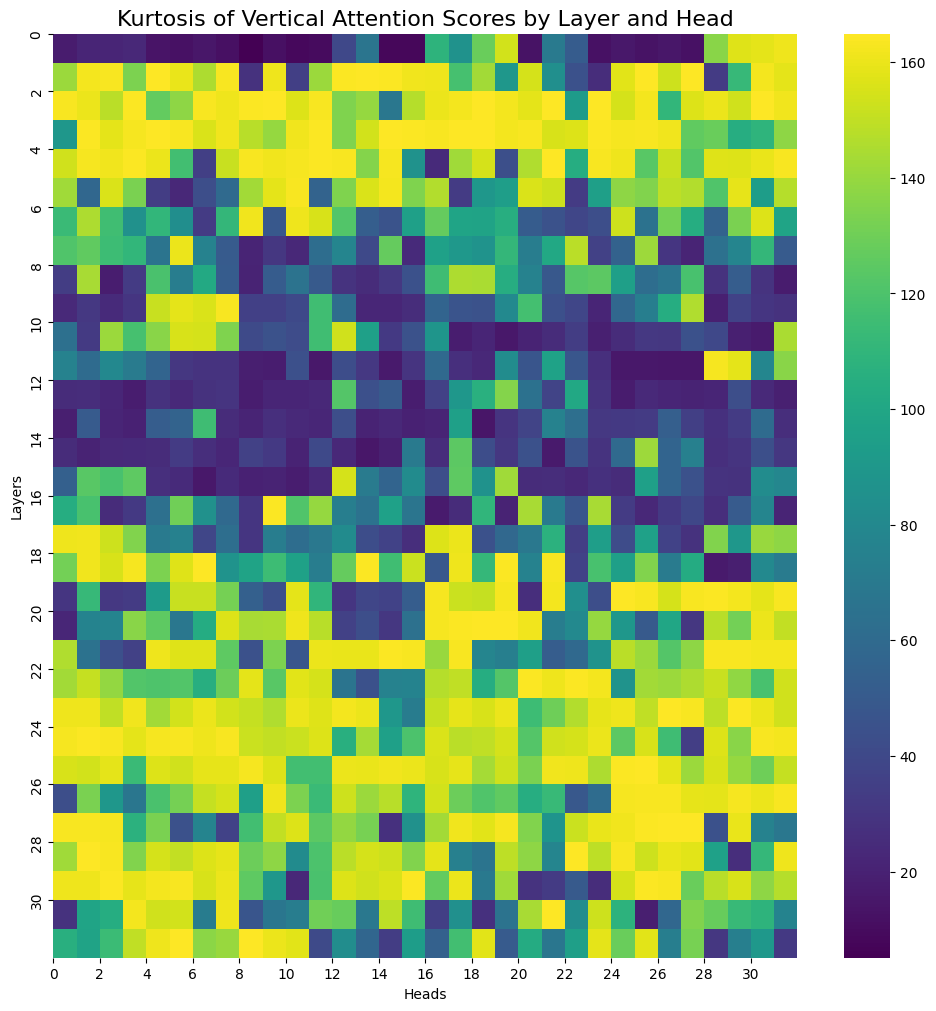

In [29]:
plt.figure(figsize=(12, 12))
sns.heatmap(layer_head_kurtosis, cmap='viridis', annot=False, fmt=".2f")
plt.title('Kurtosis of Vertical Attention Scores by Layer and Head', fontsize=16)
plt.xlabel('Heads')
plt.ylabel('Layers')
plt.xticks(np.arange(0, 32, 2), np.arange(0, 32, 2))
plt.yticks(np.arange(0, 32, 2), np.arange(0, 32, 2))
plt.show()

In [15]:
num_top = 20  # Number of heads to select
# Flatten and get indices of top 20 kurtosis values
flat_indices = np.argsort(layer_head_kurtosis.flatten())[::-1][:num_top]
layer_indices, head_indices = np.unravel_index(flat_indices, layer_head_kurtosis.shape)
top_20_heads = list(zip(layer_indices, head_indices))

print("Top 20 heads by kurtosis (layer, head):")
for i, (layer, head) in enumerate(top_20_heads):
    print(f"{i+1:2d}: Layer {layer}, Head {head}, Kurtosis: {layer_head_kurtosis[layer, head]:.3f}")

Top 20 heads by kurtosis (layer, head):
 1: Layer 4, Head 12, Kurtosis: 3315.997
 2: Layer 1, Head 20, Kurtosis: 3315.996
 3: Layer 3, Head 18, Kurtosis: 3315.996
 4: Layer 25, Head 20, Kurtosis: 3315.977
 5: Layer 3, Head 17, Kurtosis: 3315.970
 6: Layer 3, Head 4, Kurtosis: 3315.958
 7: Layer 29, Head 24, Kurtosis: 3315.956
 8: Layer 25, Head 22, Kurtosis: 3315.951
 9: Layer 1, Head 26, Kurtosis: 3315.936
10: Layer 1, Head 13, Kurtosis: 3315.917
11: Layer 1, Head 18, Kurtosis: 3315.903
12: Layer 29, Head 27, Kurtosis: 3315.902
13: Layer 29, Head 25, Kurtosis: 3315.878
14: Layer 23, Head 29, Kurtosis: 3315.871
15: Layer 29, Head 26, Kurtosis: 3315.869
16: Layer 28, Head 5, Kurtosis: 3315.808
17: Layer 28, Head 22, Kurtosis: 3315.804
18: Layer 22, Head 20, Kurtosis: 3315.793
19: Layer 24, Head 9, Kurtosis: 3315.783
20: Layer 7, Head 5, Kurtosis: 3315.768


In [32]:
layer_head_kurtosis

array([[ 17.08099185,  21.67005816,  21.92928422, ..., 157.32193328,
        158.12610675, 160.99842116],
       [140.72391229, 162.1476046 , 163.66279866, ..., 112.36201009,
        162.04440256, 158.32120539],
       [163.11162574, 160.3410727 , 148.51745555, ..., 153.18028109,
        164.543662  , 161.74851171],
       ...,
       [160.80940013, 160.94415598, 163.73998173, ..., 155.52954915,
        137.94510236, 147.4336097 ],
       [ 27.99713131,  98.13764363, 103.88091749, ..., 112.49268447,
        108.47360251,  76.83236214],
       [106.06968913,  98.10967789, 114.17953552, ...,  73.75464946,
         90.56534376,  31.63630797]])

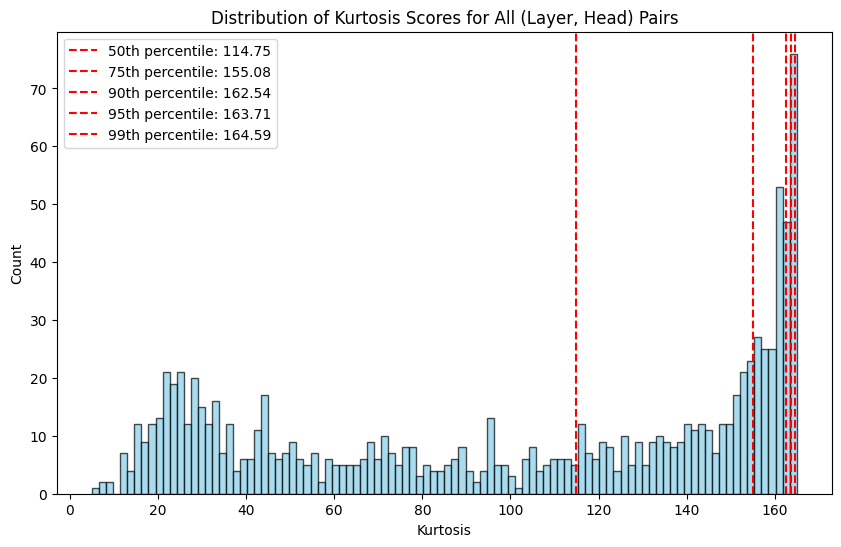

In [34]:
import matplotlib.pyplot as plt
import numpy as np
flat_kurtosis = layer_head_kurtosis.flatten()
plt.figure(figsize=(10,6))
plt.hist(flat_kurtosis, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Kurtosis Scores for All (Layer, Head) Pairs')
plt.xlabel('Kurtosis')
plt.ylabel('Count')
# Plot percentiles
for p in [50, 75, 90, 95, 99]:
    perc = np.percentile(flat_kurtosis, p)
    plt.axvline(perc, color='red', linestyle='--', label=f'{p}th percentile: {perc:.2f}')
plt.legend()
plt.show()